<div align="center">
    <h1>DS-210: Programming for Data Science</h1>
    <h1>Lecture 19</h1>
</div>

1. Algorithm Design
2. Greedy algorithms
3. Divide and conquer

# 1. Algorithm Design

## Big picture

Review a few approaches to algorithm design:
* Greedy approach 
* Divide and conquer 

Others:
* Dynamic Programming
* Branch and Bound
* Backtracking

You'll likely see these in DS320 -- Algorithms for Data Science

## Why do we care about algorithm design?

* Many problems share similar structure
* Having an algorithmic approach for a certain style of problem makes things a lot easier!
* Different approaches have tradeoffs depending on what you want to prioritize

# 2. Greedy algorithms


## Greedy algorithms

* Make locally best (or any) decision towards solving a problem

## Warm Up: Coin Change Problem

You are a cashier and you need to give $0.43 back to your customer.

**Problem:** We want to find the smallest number of coins that sum up to a given value.

**Assumption:** We're not limited by number of coins in any denomination.

**Input:** Set of coin denominations, Target value

**Output:** Minimal set of coins adding up to value

What would a greedy approach look like here?

<br><br><br>

**Idea:** Pick the largest denomination for the remaining value and repeat until done.
<br><br><br>

In [2]:
fn coin_change(denominations: &[usize], value: usize) {
    // Arguments:
    // denominations: list of coin denominations
    // value: target value

    // count notes using Greedy approach
    let mut coin_counter = vec![0; denominations.len()];
    
    let mut remainder = value;
    for i in 0..denominations.len() {
        // will at least one of the current denomination work?
        if remainder >= denominations[i] {
            // check how many of denomination i we can use.
            coin_counter[i] = remainder / denominations[i];
            remainder = remainder % denominations[i];
        }
    }
     
    // Print notes
    println!("Currency Count ->");
    for i in 0..denominations.len() {
        if coin_counter[i] != 0 {
            println!("{} : {}", denominations[i], coin_counter[i]);
        }
    }
}

In [3]:
let denoms = [25,10,5,1];
let val = 41;
coin_change(&denoms, val);

Currency Count ->
25 : 1
10 : 1
5 : 1
1 : 1


In [4]:
// lets try a different set of denominations
let denoms = [25,15,1];
let val = 30;
coin_change(&denoms, val);

Currency Count ->
25 : 1
1 : 5


**Warning:** The greedy approach is only optimal for certain sets of denominations! These are known as *canonical coin systems*.

> Canonical Coin System:
>
> For the greedy algorithm to work correctly and always give the minimum number of coins, the coin denominations must have the following property:
> 
> * The denominations must be in a "canonical" system, meaning that each coin value is at least twice the value of the next smaller denomination.
> 
> This fails because 25 is not at least twice the value of 15.
> 
> When this property doesn't hold (like in our example with `[25, 15, 1]`), we need to use a more sophisticated algorithm like dynamic programming to find the optimal solution.


Is there a country with an non-canonical coin system?

In [5]:
// United Kingdom before decimalization in 1971
let denoms = [30,24,12,6,3,1];
let val = 48;
coin_change(&denoms, val);

Currency Count ->
30 : 1
12 : 1
6 : 1


We could have done better with 2x 24p.

### Data science connection in a future lecture

* Heuristics for creating decision trees
  * select "best" single split and recurse

## Example we have seen
* Shortest paths (Dijkstra's algorithm)
  * select the vertex known to be closest
  * try routing paths through it
  * **Gives globally optimal solution!!!**

## Another Example: Minimum spanning tree

Find cheapest overall subset of edges so that the graph is connected
  
* Kruskal's algorithm: keep adding the cheapest edge that connects disconnected groups vertices

* Complexity $O(E*log(E))$
  
### Why is MST useful?

* Connecting N locations with fiber using the least amount of fiber

* Traveling salesman

## Algorithm Outline

Disconnect all edges...

1. Find the cheapest edge remaining
2. Look at the 2 nodes it connects and find the root of the tree they belong to
3. If they belong to the same tree go back to step 1
4. Else join the two trees into a single tree

### Define Graph Structure

We'll define a modified graph structure that simultaneously represents a
_weighted undirected graph_ and a _tree_.

In [8]:
type Vertex = usize;
type Distance = usize;
type Edge = (Vertex, Vertex, Distance);

#[derive(Debug,Copy,Clone)]
struct Outedge {
    vertex: Vertex,
    length: Distance,
}

type AdjacencyList = Vec<Outedge>;

// We're updating this struct to include parent and rank
#[derive(Debug)]
struct Graph {
    n: usize,
    outedges: Vec<Edge>,  // list of edges
    parent: Vec<Vertex>,  // parent[i] is the parent ID of node i
    rank: Vec<usize>,     // how deep is the tree rooted at this node?
}

impl Graph {
    fn create_undirected(n:usize, outedges:Vec<Edge>) -> Graph {
        // Create a graph from a list of edges
        //
        // This function creates a graph from a list of edges and initializes
        // the parent and rank vectors.  It also sorts the edges by distance.
        // Internally, the graph is represented as a list of edges, a parent
        // vector, and a rank vector, with parents and ranks indexed in the
        // same order as the outedges vector.
        //
        // Arguments:
        //     n: number of nodes
        //     outedges: list of edges
        // Returns:
        //     Graph: a graph with the given number of nodes and edges

        // Initialize parent and rank vectors
        let parent: Vec<Vertex> = vec![];
        let rank: Vec<usize> = vec![];

        // Create the graph
        let mut g = Graph{n,outedges,parent,rank};

        // Sort the edges by distance  O(n log n)
        g.outedges.sort_by(|a, b| a.2.cmp(&b.2));

        // Initialize parent and rank vectors
        // From a tree perspective, it's just a forest of single node "trees"
        for node in 0..g.n {
            // The parent and rank vectors are indexed in the same order
            // as the outedges vector
            g.parent.push(node);  // set each node to be its own parent
            g.rank.push(0);      // set the rank of each node to 0
        }
        g
    }
    
    fn find(&mut self, i:Vertex) -> Vertex {
        // Recursively find the root of the tree rooted at i.
        // O(log n) -- logarithmic time
        //
        // Arguments:
        //     i: node to find the root of
        // Returns:
        //     Vertex: the root of the tree rooted at i

        if self.parent[i] != i {
            self.parent[i] = self.find(self.parent[i]);
        }
        return self.parent[i];
    }

    fn union(&mut self, i:Vertex, j:Vertex) {
        // Union the trees rooted at i and j by making the root of the
        // smaller ranked tree a child of the root of the larger tree. 
        // O(1) -- constant time
        //
        // Arguments:
        //     i: node to union with
        //     j: node to union with

        if self.rank[i] < self.rank[j] {
            self.parent[i] = j;
        } else if self.rank[i] > self.rank[j] {
            self.parent[j] = i;
        } else {
            self.parent[j] = i;
            self.rank[i] += 1;
        }
    }
}

Let's consider the following graph.

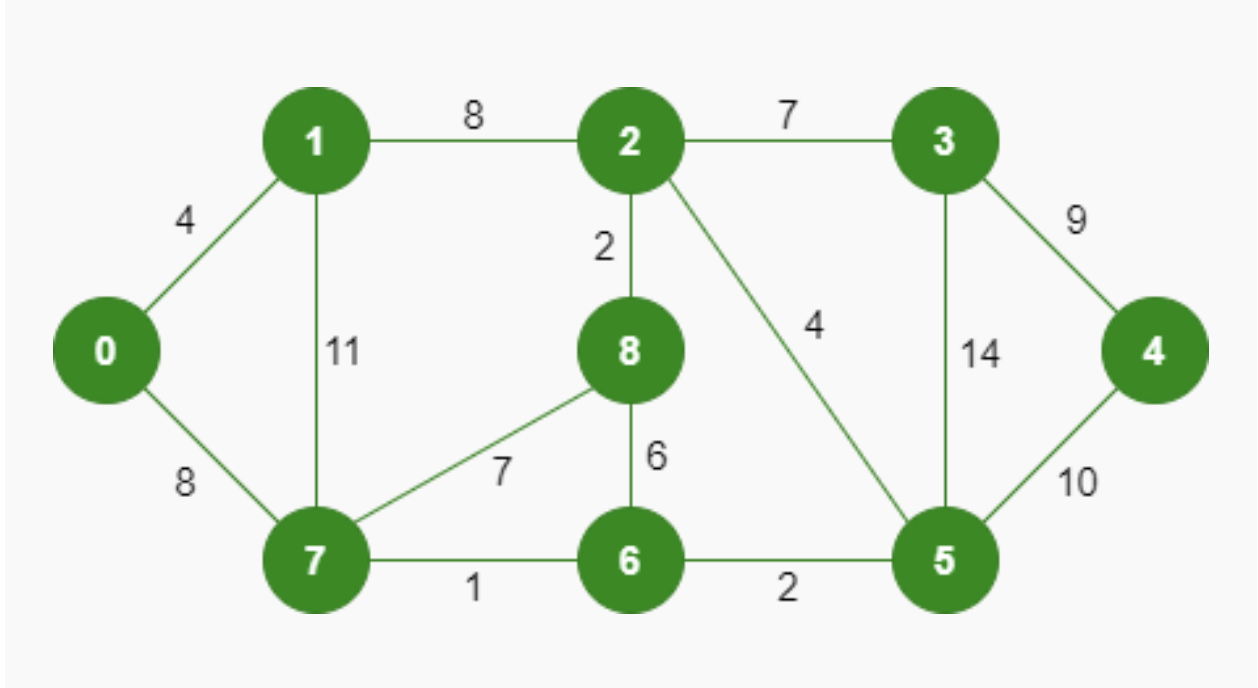

In [9]:
// Let's create the graph
let n = 9;
let edges: Vec<Edge> = vec![(7,6,1),(8,2,2),(6,5,2),(0,1,4),(2,5,4),(8,6,6),(2,3,7),(7,8,7),(0,7,8),(1,2,8),(3,4,9),(5,4,10),(1,7,11),(3,5,14)];
let mut g = Graph::create_undirected(n, edges);
g

Graph { n: 9, outedges: [(7, 6, 1), (8, 2, 2), (6, 5, 2), (0, 1, 4), (2, 5, 4), (8, 6, 6), (2, 3, 7), (7, 8, 7), (0, 7, 8), (1, 2, 8), (3, 4, 9), (5, 4, 10), (1, 7, 11), (3, 5, 14)], parent: [0, 1, 2, 3, 4, 5, 6, 7, 8], rank: [0, 0, 0, 0, 0, 0, 0, 0, 0] }

### Kruskal's MST


In [10]:
impl Graph {
    fn KruskalMST(&mut self) -> Vec<Edge> {
        // Arguments:
        // self: a mutable reference to the graph
        // Returns:
        // Vec<Edge>: a vector of edges that form the minimum spanning tree

        // Initialize the result vector and counters
        let mut result: Vec<Edge> = vec![];
        let mut num_mst_e = 0;
        let mut next_edge = 0;  // start with the smallest weighted edge

        // Loop until we built a tree that has n-1 edges
        // A tree with n nodes has n-1 edges
        while num_mst_e < self.n - 1 {  // O(n)
            let (u,v,w) = self.outedges[next_edge];
            next_edge = next_edge + 1;

            let x = self.find(u);  // find the root of u
            let y = self.find(v);  // find the root of v
            
            // If u and v are in different trees, add the edge to the MST
            if x != y {
                num_mst_e += 1;
                result.push((u,v,w));
                self.union(x,y);  // join the two trees at their roots
            }
        }
        result
    }
}

### Complexity Analysis

* `while` loop -- $n$ times
* Insde the loop
    * $\log n$ for each of 2 `.find()`
    * Constant time for the `.union()`

$$
\approx  n \times (2\log n + \mathrm{Constant})
$$

Which, in order notation would be:
<br><br><br><br><br>

$$
O(n \log n)
$$

In [11]:
let result = g.KruskalMST();
let mut min_cost = 0;
for (u,v,w) in result {
    min_cost += w;
    println!("{} -- {} == {}", u, v, w)
}
println!("Spanning Tree Cost {}", min_cost);

7 -- 6 == 1
8 -- 2 == 2
6 -- 5 == 2
0 -- 1 == 4
2 -- 5 == 4
2 -- 3 == 7
0 -- 7 == 8
3 -- 4 == 9
Spanning Tree Cost 37


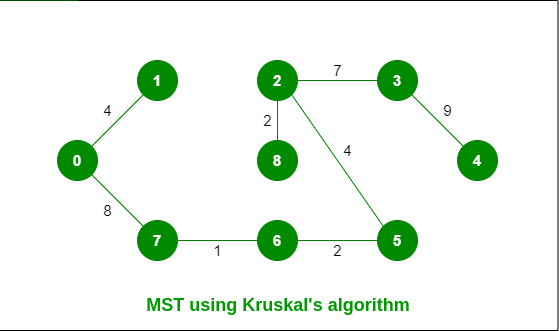

### Other interesting graph problems (independent reading if you are interested)
* Matching: matching conference attendees to available desserts they like
  * Another formulation: maximum size set of independent edges in graph
  * Keep adding edges as long as you can
  * This will give factor 2 approximation

## Traveling Salesman Approximation using MST

<img src="./mst-graph-1.png" width="40%">
<img src="./mst-graph-2.png" width="40%">

* Make a MST
* Pick an arbitrary vertex to be the root of the tree
* Run DFS from the root
* Shortcut where you can to shorten the tour.  

For example a DFS of the above tree might yield:

0 - 1 - 0 - 7 - 6 - 5 - 2 - 8 - 2 - 3 - 4 - 3 - 2 - 5 - 6 - 7 - 0

Whenever you go to a new node through an already visited node, check to see if you can get there directly with less cost:

0 - 1 - (0) - 7 - 6 - 5 - 2 - 8 - 2 - 3 - 4 - (3 - 2) - 5 - 6 - 7 - 0

### This is still not optimal but guaranteed to be within 2x of optimal (proof beyond our scope)

## Greedy Algorithms Recap

* They often work well in practice
* They are polynomial on the size of their input (e.g. $n^2$ or better)
* They don't always find the best solutions (recall the coin problem with non-canonical denominations)
* They definitely don't prove that P != NP :-)

### P vs NP

* P represents the class of problems that can be solved in polynomial time.

* NP represents the class of problems where solutions are unknown, but solutions can be verified in polynomial time

* If a problem is NP, is it also P?

* Answer this and [get $1M](https://www.claymath.org/millennium/p-vs-np/)

# 3. Divide and conquer

Applies to a class of problem where it might be difficult to solve directly, but
the problem can be easily subdivided.

If your problem is too difficult:

* partition it into subproblems
* solve the subproblems
* combine their solutions into a solution to the entire problem

We'll look at 3 algorithms
1. Simple averaging
2. Merge Sort
3. Quick Sort

## Warm Up: Taking the average of an array

How can we use a divide and conquer approach to taking the average of an array?

<br>
<div align="center">
    <b>How would you do this?</b>
</div>

In [12]:
fn divide_and_conquer_average(arr: &[f64]) -> (f64, usize) {
    // A divide and conquer approach to finding the average of an array using
    // recursion.
    //
    // This function takes a slice of floating point numbers and returns a tuple
    // containing the average and the number of elements in the array.
    //
    // Arguments:
    //     arr: A slice of floating point numbers
    //
    // Returns:
    //     A tuple containing the average and the number of elements in the array

    if arr.len() == 1 {
        return (arr[0], 1);
    } else {
        let mid = arr.len() / 2;
        let (left_sum, left_count) = divide_and_conquer_average(&arr[..mid]);
        let (right_sum, right_count) = divide_and_conquer_average(&arr[mid..]);
        return (left_sum + right_sum, left_count + right_count)
    }
}

In [14]:
let arr = [1.0, 28.0, 32.0, 41.0, 25.0];
let (total, num) = divide_and_conquer_average(&arr);
println!("The average is {}", total/num as f64);

let straightforward_avg = arr.iter().sum::<f64>() / arr.len() as f64;
println!("The straightforward average is {}", straightforward_avg);


The average is 25.4
The straightforward average is 25.4


Is this actually more efficient than the straightforward approach?

**No!** Why?
<br><br><br><br>



**Answer:**

We are subdividing to $\log_2 N$ levels and at level $n$ we are doing $2^n$
additions, so total

$$
\sum_{n=0}^{\log_2 N} 2^n
$$

The sum of the first $k+1$ terms of a geometric series is:

$$ \sum_{n=0}^{k} r^n = \frac{r^{k+1} - 1}{r - 1} $$

Plug in $r = 2$ and $k = \log_2 N$ and simplify.

$$ \sum_{n=0}^{\log_2 N} 2^n = \frac{2^{\log_2 N + 1} - 1}{2 - 1} = 2^{\log_2 N + 1} - 1 $$

Using properties of logarithms:

$$ 2^{\log_2 N + 1} = 2^{\log_2 N} \cdot 2^1 = N \cdot 2 = 2N $$


Final Answer:

$$ \sum_{n=0}^{\log_2 N} 2^n = 2N - 1 $$

This holds for N a power of 2.


It is still a useful toy example though

**Our plan:** see two classic divide and conquer sorting algorithms

<br>
<div align="center">
    <b>How would you do this?</b>
</div>

## Merge Sort

Recursively:
  * sort the first half
  * sort the second half
  * merge the results

<div align="center">
    <b>Complexity for n elements?</b>
</div>

* Merging two lists of $Q$ and $R$ elements takes $O(R+Q)$ time, or $O(n/2 + n/2)$
* $O(\log n)$ levels of recursion: $O(n)$ work on each level
* $O(n \log n)$ time overall

BUT
* Difficult to do in-place (requires extra memory allocations for intermediate results)

## Implementing merging

In [15]:
fn merge(v1:Vec<i32>, v2:Vec<i32>) -> Vec<i32> {
    // Take two sorted vectors and merge them into a single sorted vector
    //
    // This function takes two vectors of integers and returns a new vector
    // containing all the elements from both vectors in sorted order.
    //
    // Arguments:
    //     v1: A sorted vector of integers
    //     v2: A sorted vector of integers
    //
    // Returns:
    //     A new vector containing all the elements from both vectors in sorted order

    let (l1,l2) = (v1.len(), v2.len());
    let mut merged = Vec::with_capacity(l1+l2); // preallocate memory
    let (mut i1, mut i2) = (0,0);
    
    while i1 < l1 {
        if (i2 == l2) || (v1[i1] <= v2[i2]) {
            merged.push(v1[i1]);
            i1 += 1;
        } else {
            merged.push(v2[i2]);
            i2 += 1;
        }
    }
    while i2 < l2 {
        merged.push(v2[i2]);
        i2 += 1;
    }
    merged
}

In [16]:
let v1 = vec![3,4,8,11,12];
let v2 = vec![1,2,3,9,22];
merge(v1,v2)

[1, 2, 3, 3, 4, 8, 9, 11, 12, 22]

## Implementing Merge Sort

Now implement divide and conquer via recursion.

In [15]:
fn merge_sort(input:&[i32]) -> Vec<i32> {
    // Implement merge sort using divide and conquer
    //
    // This function takes a slice of integers and returns a new vector
    // containing all the elements from the input slice in sorted order.
    //
    // Arguments:
    //     input: A slice of integers
    //
    // Returns:
    //     A new vector containing all the elements from the input slice in sorted order

    if input.len() <= 1 {
        input.to_vec()
    } else {
        let split = input.len() / 2;
        let v1 = merge_sort(&input[..split]);
        let v2 = merge_sort(&input[split..]);
        merge(v1,v2)
    }
}

In [16]:
let v = vec![2,4,21,6,2,32,62,0,-2,8];
merge_sort(&v)

[-2, 0, 2, 2, 4, 6, 8, 21, 32, 62]

See [`merge_sort` Cargo project](./merge_sort/) if you want to debug.

## Quick Sort

* Select an arbitrary (random?) element $x$ from the array
* Partition your vector:
  * Move elements lower than $x$ to the left
  * Move elements greater than $x$ to the right
  * which will result in 3 partitions:
    1. the left partition
    2. the middle partition (in the correct location(s))
    3. the right partition
* Repeat again for the left and right partitions

<div align="center">
    <b>Complexity for n elements?</b>
</div>

* Partitioning $k$ elements takes $O(k)$ time
* Intuition: The size of the problem usually decreases by constant factor in a recursive call
* Expected time: $O(n \log n)$ time overall (probabilistic algo analysis)
    * but $O(n^2)$ worst case when the array is already sorted and pivot is always first or last element.
    * $n$ recursive calls and each level does about $n$ comparisons.

## Implementing partitioning

In [6]:
fn partition(input:&mut [i32], pivot: i32) -> (usize,usize) {
    // move numbers lower than pivot to the left
    let mut left = 0;
    for i in 0..input.len() {
        if input[i] < pivot {
            input.swap(i,left);
            left += 1;
        }
    }
    // now input[..left] are all numbers lower than pivot

    // move numbers greater than pivot to the right
    let mut right = input.len();
    for i in (left..input.len()).rev() {
        if input[i] > pivot {
            right -= 1;
            input.swap(i,right);
        }
    }
    // input[right..]: numbers greater than pivot
    
    // left is the index of the pivot and
    // right is the index of the first number greater than pivot
    (left,right)
}

## Implementing QuickSort

In [7]:
:dep rand
use rand::Rng;

fn quicksort(input:&mut [i32]) {
    if input.len() >= 2 {    
        // pivot = random element from the input
        let pivot = input[rand::rng().random_range(0..input.len())];

        // partition the input array around the pivot
        let (left,right) = partition(input, pivot);
        println!("\nL {} R {} P {} P {}", left, right, pivot, input[left]);
        
        println!("Left side {:?}", &input[..left]);
        println!("Right side {:?}", &input[right..]);
        
        quicksort(&mut input[..left]);
        quicksort(&mut input[right..]);
    }
}

In [8]:
let mut q = vec![145,12,3,7,83,12,8,64];
quicksort(&mut q);
println!("{:?}", q);


L 7 R 8 P 145 P 145
Left side [12, 3, 7, 83, 12, 8, 64]
Right side []

L 6 R 7 P 83 P 83
Left side [12, 3, 7, 12, 8, 64]
Right side []

L 5 R 6 P 64 P 64
Left side [12, 3, 7, 12, 8]
Right side []

L 1 R 2 P 7 P 7
Left side [3]
Right side [12, 12, 8]

L 1 R 3 P 12 P 12
Left side [8]
Right side []
[3, 7, 8, 12, 12, 64, 83, 145]


See [`quicksort` Cargo project](./quicksort/) to single step debug.

## Recap of Divide and Conquer algorithms

* They divide the problems into smaller subproblems
* They are always polynomial in execution time
* They tell us nothing about P and NP

## Recursion with mutable references can be quite hard in Rust due to the borrow checker

A relatively simple example of the problem.

We want to make another mutable reference to the first element and pass the rest of the slice to the recursive call.

In [ ]:
fn process_slice(slice: &mut [i32]) {
    if !slice.is_empty() {
        let first = &mut slice[0]; // Mutable borrow of the first element
        process_slice(&mut slice[1..]); // Recursive call borrows the rest of the slice mutably
        *first *= 2; // Attempt to modify the first element after recursive call
    }
}

fn testme() {
    let mut numbers = [1, 2, 3, 4];
    process_slice(&mut numbers);
    println!("{:?}", numbers);
}

testme();

Error: cannot borrow `*slice` as mutable more than once at a time

### The unsafe language feature allows you to bypass the borrow checker but it is not recommended and not covered in this class.   A very small example below

In [4]:
fn process_slice(slice: *mut i32, len: usize) {
    if len == 0 {
        return;
    }

    unsafe {
        // Access and modify the first element
        let first = &mut *slice;

        // Recursive call with the rest of the slice
        let rest = slice.add(1); // Advance the pointer to the next element
        process_slice(rest, len - 1);

        *first *= 2;
    }
}

fn testme() {
    let mut numbers = [1, 2, 3, 4];
    let len = numbers.len();

    unsafe {
        process_slice(numbers.as_mut_ptr(), len);
    }

    println!("{:?}", numbers); // Output: [2, 4, 6, 8]
}
testme();

[2, 4, 6, 8]


# Piazza In-Class Poll

https://piazza.com/class/m5qyw6267j12cj/post/405

